# TP DT

Save the notebook as either PDF or HTML and make sure all the results are saved correctly (I won't run them and the original format does not save the results automatically), **and put your name in the filename**.

<div class="alert alert-success">
<b>Questions are in green boxes.</b>
The maximum time you should spend on each question is given as indication only. If you take more time than that, then you should come see me.
</div>
<div class="alert alert-info" role="alert"><b>Analyzes are in blue boxes.</b> You should comment on your results in theses boxes (Is it good? Is it expected? Why do we get such result? Why is it different from the previous one? etc)
</div>

In [ ]:
%%shell
jupyter nbconvert --to html /PATH/TO/YOUR/NOTEBOOKFILE.ipynb

In [1]:
import jax
import jax.numpy as jnp
import numpy as np
import gzip
import pickle
import matplotlib.pyplot as plt
import time

For this lab, we will use the bluebell dataset. It consists of $64\times 64$ color images, which we will have to flatten into $12k$ dimensional vectors. The code for the dataset comes with several train/val/test splits, but in this notebook, we will use the first split and do our own cross-validation routines.

In [ ]:
!unzip bluebell_64.zip


0


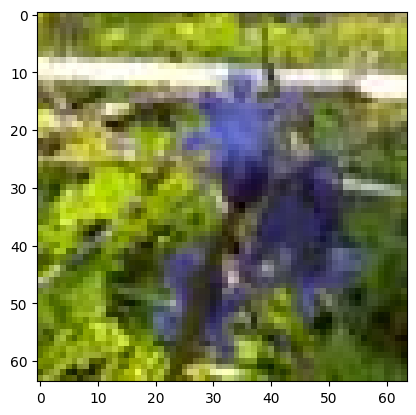

In [8]:
# Load the dataset
from bluebell import Bluebell
X_train_ds = Bluebell('bluebell_64', 'train', split=0)
X_val_ds = Bluebell('bluebell_64', 'val', split=0)
X_train = np.array([img.flatten()/127.5 - 1. for img, lab in X_train_ds])
y_train = np.array([lab for img, lab in X_train_ds])
X_val = np.array([img.flatten()/127.5 - 1. for img, lab in X_val_ds])
y_val = np.array([lab for img, lab in X_val_ds])
plt.imshow(X_train[0].reshape(64, 64, 3)/2+0.5)
print(y_train[0])


Next, we want to reduce the number of dimensions that will be search through with the decision trees. Since our images are $64\times 64\times 3$ values, this leads to a very high dimensional space that has to be searched at each step. However, dimensions where all images have the same value, or very close values, will never be selected in the tree because they do not provide a good gain.

We will thus select only the 2048 dimension with the highest variance to perform our analysis.

In [9]:
dim = jnp.argsort(X_train.std(axis=0), descending=True)[0:2048] #it's close the the idea of PCA ..maximizing the variance
X_train = jnp.array(X_train[:, dim])
X_val = jnp.array(X_val[:, dim])
print(X_train.shape, X_val.shape)

(1200, 2048) (300, 2048)


In [10]:
print(np.unique(y_train))

[ 0  1  2  3  4  5  6  7  8  9 10 11]


## Implementing a randomized Decision Tree

<div class="alert alert-success">
    <b>Q1.</b> Implement the code of a function that finds an optimal threshold along a given dimension, using the $0-1$ loss with specified example weights and test it on the 150th dimension. To speed-up things, we will only consider 8 thresholds between the minimum and maximum value (use 'linspace'). Compare it to assigning a unique label to all samples. You should get a significant decrease of loss from ~0.92 (random 1/12 chance) to ~0.84. <i>(Indicative time: 10 minutes for a slow version, but take the extra 20 minutes to have a parallel version testing all thresholds at once that runs in under 1s, it is worth it for the next questions.)</i>
</div>

In [11]:
'''
takes arguements
y_pred: prediction
y_true: true labels
weights: weights for each example
'''
@jax.jit
def zeroOneLoss(y_pred, y_true, weights):
    return (weights * (y_pred != y_true)).sum(axis=0)/(1e-12+weights.sum(axis=0))

In [12]:
import jax.nn

'''
takes arguments
X: training samples
y: training labels
dim: dimension to use
w: weight associated to each example (can be True/False or 1/0 to remove some examples)
returns the gain and the threshold
# '''

@jax.jit
def findBestTh(X, y, dim, w):
    n = X.shape[0]
    theta = jnp.linspace((X[:, dim]).min(), (X[:, dim]).max(), 8)
    C_0 = zeroOneLoss(jnp.full((n, 12), jnp.arange(12)), y[:, None], w[:, None]).min()
    mask_left = X[:, dim, None] < theta[None, :]

    C_left = zeroOneLoss(jnp.full((n, 12), jnp.arange(12))[:, None, :], y[:, None, None], mask_left[:, :, None]).min(axis=1)
    C_right = zeroOneLoss(jnp.full((n, 12), jnp.arange(12))[:, None, :], y[:, None, None], ~mask_left[:, :, None]).min(axis=1)
    C = C_0 - (jnp.mean(mask_left, axis=0).T * (C_left - C_right) +  C_right)
    idx = C.argmax()
    return  C[idx] ,theta[idx]


In [ ]:
%%time

G, th = findBestTh(X_train, y_train, 150, jnp.ones(len(y_train)))
print(G, th)

w_below = jnp.ones(len(X_train)) * (X_train[:, 150] <= th)
w_above = jnp.ones(len(X_train)) * (X_train[:, 150] >= th)

print("Nonzero weights below or equal to threshold:", jnp.count_nonzero(w_below))
print("Nonzero weights above or equal to threshold:", jnp.count_nonzero(w_above))

G, th = findBestTh(X_train, y_train, 150, w_below)
print(G, th)
G, th = findBestTh(X_train, y_train, 150, w_above)
print(G, th)



0.07833338 -0.42857143
Nonzero weights below or equal to threshold: 573
Nonzero weights above or equal to threshold: 627
-0.012853384 -0.42857143
0.011746407 -0.42857143
CPU times: user 497 ms, sys: 7.7 ms, total: 505 ms
Wall time: 506 ms


<div class="alert alert-info" role="alert"><b>Analyze your results in this box.</b> Observing what we got above , there is a bug in the assigning zeros to weights after doing the split, because we get always the same th, which can't be true for all cases. Selecting 8 values for splits often fails to effectively divide the data, typically resulting in trivial divisions such as 0 versus X or its reverse, without genuinely informative splits. This choice needs refinement, particularly by incorporating weights to ensure that the chosen thresholds represent the underlying data distribution more accurately.
Additionally, a repeated issue arises from not dynamically updating the selection filter; without changes, we consistently select the same dimensions and thresholds, which leads to redundant and ineffective splits. Addressing this by updating the filter criteria and using indexed masks for splitting ensures more logical results and avoids repetitive selection of the same dimension and threshold in subsequent iterations.</div>

We can vectorize over the dimension by using vmap. The batched function can now operate on a array of dimensions.

In [13]:
batched_findBestTh = jax.vmap(findBestTh, in_axes=(None, None, 0, None), out_axes=0)

<div class="alert alert-success">
    <b>Q2.</b> Wrap the batched function in a function that test all dimensions to find the best combination of component and threshold. Use blocks of 256 dimensions to process at a time, as we found it a good setup with respect to speed (You can change those values later to optimize for speed).Test it on the entire train set and make sure it obtains the lowest error.<i>(Indicative time: It could take you 15 minutes to an hour to code and should run in less than 5 seconds.)</i>
</div>

In [14]:
batched_findBestTh_again = jax.vmap(batched_findBestTh, in_axes=(None, None, 0, None), out_axes=0)

In [15]:
@jax.jit
def findBestDTh(X, y, w):
    dim_batches = jnp.array(jnp.split(np.arange(2048), 8))
    Gains, ths = batched_findBestTh_again(X, y, dim_batches, w)
    Gains = Gains.flatten()
    ths = ths.flatten() #to avoid the loops
    best_dim = jnp.argmax(Gains)
    best_gain = Gains[best_dim]
    best_th = ths[best_dim]

    return best_gain, best_dim, best_th

In [24]:
%%time
g, d, t = findBestDTh(X_train, y_train, jnp.ones(len(X_train)))
print("gain: {} dim: {} th: {}".format(g, d, t))

w_below = jnp.ones(len(X_train)) * (X_train[:, d] <= t)
w_above = jnp.ones(len(X_train)) * (X_train[:, d] >= t)

g, d, t = findBestDTh(X_train, y_train, w_below)
print("gain: {} dim: {} th: {}".format(g, d, t))

g, d, t = findBestDTh(X_train, y_train, w_above)
print("gain: {} dim: {} th: {}".format(g, d, t))


gain: 0.08250004053115845 dim: 30 th: -0.4285714328289032
gain: -0.008686721324920654 dim: 30 th: -0.4285714328289032
gain: 0.007938623428344727 dim: 30 th: -0.4285714328289032
CPU times: user 5.83 s, sys: 1.08 s, total: 6.91 s
Wall time: 5.16 s


This aligns with the observation we had before, so I decided to split the data using indexes, to solve that bug.

<div class="alert alert-success">
    <b>Q3.</b> Implement the code of the Decision Tree class by using the previous functions. To achieve reasonable speed, loop only over dimensions that have variations (there is no threshold if all samples have the same value) in batches of 256 or more, inspired by the previous function. Do not split and slice the data but zero the associated weights instead, it is faster (all functions have the same size of arrays and are thus compiled and optimized only once). Debug it on only 256 dimensions and 256 samples, because using all dimensions/samples takes about 2 minutes. Test it on the full set with a maximum depth of 8 and a leaf size less than 10 to analyze and comment. <i>(Indicative time: It could take you 30 minutes to an hour to code and debug since it involves recursion.)</i>
</div>

We first try on the training set reduced to digits 0 and 1 with all dimensions to check that our code works.

In [17]:
#for debbuging :
x_train_01 = X_train
y_train_01 = y_train
x_val_01 = X_val
y_val_01 = y_val


x_train_01 = x_train_01[256:512, 0:256]
y_train_01 = y_train_01[0:256]
x_val_01 = x_val_01[0:100, 0:256]
y_val_01 = y_val_01[0:100]


In [18]:
class RandomizedDT():
    def __init__(self, percent_dimension=1.0, max_depth=8, max_size=20, verbose=False, space=0, pos=None , rng_key = None):
        self.max_depth = max_depth
        self.max_size = max_size
        self.percent_dimension = percent_dimension
        self.verbose = verbose
        self.space = space
        self.pos = pos
        self.left = None
        self.right = None
        self.label = None
        self.rng_key =  jax.random.key(0) if rng_key is None else rng_key

    def fit(self, X, y, w=None):
        n, p = X.shape
        w = jnp.ones(n) if w is None else w
        label = jnp.argmax(jnp.sum(jax.nn.one_hot(y, num_classes=12) * w[:, None], axis=0))
        if self.max_depth == 0 or len(w) <= self.max_size :
            self.label = label
            if self.verbose:
                print(f'{" " * self.space}Leaf: Class {self.label}, Depth {self.max_depth}')
            return

        self.rng_key, skey = jax.random.split(self.rng_key)
        acceptable_dims = jnp.nonzero(jnp.std(X, axis=0))[0]
        dims = jax.random.permutation(skey, acceptable_dims)[:int(len(acceptable_dims) * self.percent_dimension)]
        n_batches = int(len(acceptable_dims) * self.percent_dimension) // 4
        dim_batches = jnp.array(jnp.split(dims, n_batches))
        Gains, ths = batched_findBestTh_again(X, y, dim_batches, w)
        Gains = Gains.flatten()
        ths = ths.flatten()
        idx= jnp.argmax(Gains)
        self.dim, self.th = dims[idx], ths[idx]

        if self.verbose:
            print(f'{" " * self.space}Node: Gain {Gains[idx]}, Dim {self.dim}, Threshold {self.th}, Depth {self.max_depth}')

        left_mask = X[:, self.dim] <= self.th
        right_mask = ~left_mask
        self.left = RandomizedDT(self.percent_dimension, self.max_depth - 1, self.max_size, self.verbose, self.space + 3, "left" , self.rng_key)
        self.right = RandomizedDT(self.percent_dimension, self.max_depth - 1, self.max_size, self.verbose, self.space + 3, "right", self.rng_key)
        self.left.fit(X[left_mask], y[left_mask], w[left_mask])
        self.right.fit(X[right_mask], y[right_mask], w[right_mask])
        # self.left.fit(X, y, w*right_mask) #that doesn't work unfortunately
        # self.right.fit(X, y, w*left_mask)

    def predict(self, X):
        if self.label is not None :
            return jnp.array([self.label])
        return jnp.concatenate([self.left.predict([x]) if x[self.dim] < self.th else self.right.predict([x]) for x in X])

In [19]:
%%time
decision_tree = RandomizedDT(percent_dimension=1.0, max_depth= 8 ,  max_size= 10 ,verbose = True)
decision_tree.fit(x_train_01,y_train_01)
predictions  = decision_tree.predict(x_val_01)


Node: Gain 0.08203125, Dim 46, Threshold -0.4285714328289032, Depth 8
   Node: Gain 0.08461540937423706, Dim 240, Threshold -0.4464986026287079, Depth 7
      Node: Gain 0.07843142747879028, Dim 235, Threshold -0.7770308256149292, Depth 6
         Node: Gain 0.10294115543365479, Dim 67, Threshold -0.8117647171020508, Depth 5
            Node: Gain 0.11320751905441284, Dim 181, Threshold -0.9260504245758057, Depth 4
               Node: Gain 0.10344827175140381, Dim 57, Threshold -0.7355742454528809, Depth 3
                  Node: Gain 0.1304347813129425, Dim 198, Threshold -0.8745098114013672, Depth 2
                     Node: Gain 0.10526315867900848, Dim 88, Threshold -0.848739504814148, Depth 1
                        Leaf: Class 0, Depth 0
                        Leaf: Class 4, Depth 0
                     Leaf: Class 3, Depth 1
                  Leaf: Class 4, Depth 2
               Node: Gain 0.12499997019767761, Dim 231, Threshold -0.6459383964538574, Depth 3
                 

In [20]:
print(y_val_01)
print(predictions)
print("the error is : ", zeroOneLoss(predictions,  y_val_01 , jnp.ones_like(y_val_01)))

[ 0  1  2  3  4  5  6  7  8  9 10 11  0  1  2  3  4  5  6  7  8  9 10 11
  0  1  2  3  4  5  6  7  8  9 10 11  0  1  2  3  4  5  6  7  8  9 10 11
  0  1  2  3  4  5  6  7  8  9 10 11  0  1  2  3  4  5  6  7  8  9 10 11
  0  1  2  3  4  5  6  7  8  9 10 11  0  1  2  3  4  5  6  7  8  9 10 11
  0  1  2  3]
[ 8  9  5  5  3  6  7  3  0  8  9  6  6  3  6  0  7  2  2  0  2 10  7  5
  1  4  2  2  0  3  2  0  9  8 11  2  8  3  5  8  0  7  1  4  4  5  5  2
  1  3 10  4  0  2  1  0  3  5  2  8  8  4  6  2  4  2  4  0  9  5  6  7
 11  6  1  7  3  2  5  4  9  5  2  8  6  3  6  2  2  2  6  4  7  5  6  2
  2  0  1  4]
the error is :  0.97


In [21]:
print("Accuracy on the 01 validation set:", jnp.mean(predictions == y_val_01)*100 , "%")

Accuracy on the 01 validation set: 3.0 %


In [22]:
%%time
decision_tree = RandomizedDT(percent_dimension=1.0, max_depth= 8 ,  max_size= 20 ,verbose = True)
decision_tree.fit(X_train,y_train)
predictions =decision_tree.predict(X_val)

print("Accuracy on the bigger validation set:", jnp.mean(predictions == y_val)*100 , "%")
print("the error is : ", zeroOneLoss(predictions,  y_val , jnp.ones_like(y_val)))

Node: Gain 0.08250004053115845, Dim 30, Threshold -0.4285714328289032, Depth 8
   Node: Gain 0.0820244550704956, Dim 1233, Threshold 0.4554622173309326, Depth 7
      Node: Gain 0.07336956262588501, Dim 147, Threshold -0.7142857313156128, Depth 6
         Node: Gain 0.11016947031021118, Dim 1759, Threshold 0.4577031135559082, Depth 5
            Node: Gain 0.08000004291534424, Dim 1701, Threshold 0.46442580223083496, Depth 4
               Node: Gain 0.07377046346664429, Dim 2019, Threshold 0.4711484909057617, Depth 3
                  Node: Gain 0.04672896862030029, Dim 1680, Threshold 0.7422970533370972, Depth 2
                     Node: Gain 0.04166668653488159, Dim 197, Threshold -0.43977591395378113, Depth 1
                        Leaf: Class 8, Depth 0
                        Leaf: Class 6, Depth 0
                     Leaf: Class 4, Depth 1
                  Leaf: Class 1, Depth 2
               Node: Gain 0.1320754587650299, Dim 413, Threshold -0.7467787265777588, Depth 3
   

<div class="alert alert-info" role="alert"><b>Analyze your results in this box. </b> Achieving 36% accuracy on the validation set is a promising start, and while it's a decent result for now, there's room for improvement. We'll aim to enhance this by implementing Random Forests and Boosting techniques. Personally, I am satisfied with this initial outcome. Additionally, using vmap has significantly sped up our computations, enabling us to reach these results in just 1 minute and 30 seconds, which is quite efficient.</div>

<div class="alert alert-success">
    <b>Q4.</b> Use cross-validation on the full digit dataset (0-9) to select a reasonnable depth between 2 and 8, using random splits of half the training set to save on training time. <i>(Indicative time: maximum 10 minutes to code, about 20 minutes to run)</i>

In [ ]:
def cross_validation_tree_depths(X_train, y_train, depths, splits=5, subset_size=0.5):
    avg_accuracies = []
    deviations = []
    for current_depth in depths:
        fold_accuracies = []
        for i in range(splits):
            # Randomly shuffle indices for cross-validation
            key,skey = jax.random.split(jax.random.key(i))
            perm_indices = jax.random.permutation(skey, len(y_train))
            cut_off = int(len(y_train) * subset_size)

            indices_train = perm_indices[:cut_off]
            indices_val = perm_indices[cut_off:2*cut_off]

            X_sub_train = X_train[indices_train]
            y_sub_train = y_train[indices_train]
            X_sub_val = X_train[indices_val]
            y_sub_val = y_train[indices_val]

            # Initialize and train the decision tree at the current depth
            decision_tree = RandomizedDT(max_depth=current_depth, verbose=False)
            decision_tree.fit(X_sub_train, y_sub_train)

            # Evaluate the decision tree
            predicted = decision_tree.predict(X_sub_val)
            accuracy = jnp.mean(predicted == y_sub_val)
            fold_accuracies.append(accuracy)

        accuracies_np = jnp.array([fold_accuracies])
        avg_accuracies.append(jnp.mean(accuracies_np))
        deviations.append(jnp.std(accuracies_np))

    # Determine the optimal tree depth
    optimal_depth = depths[jnp.argmax(jnp.array(avg_accuracies))]

    return optimal_depth, avg_accuracies, deviations

In [ ]:

%%time

depths = range(2, 9)
optimal_depth, avg_accuracies, deviations = cross_validation_tree_depths(X_train, y_train, depths)

CPU times: user 6min 26s, sys: 1min 5s, total: 7min 31s
Wall time: 6min 4s


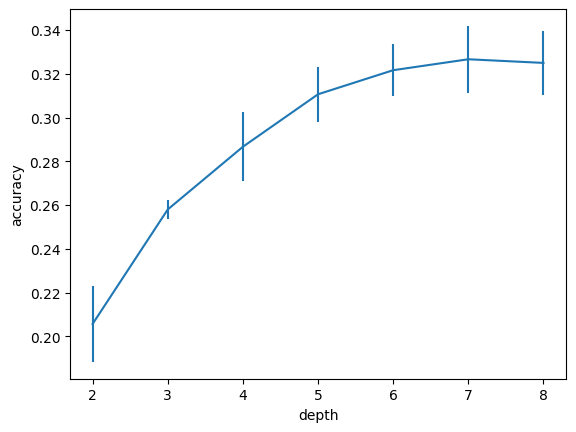

Best depth: 7


In [ ]:
plt.errorbar(depths, avg_accuracies, yerr= deviations)
plt.xlabel("depth")
plt.ylabel("accuracy")
plt.show()

print("Best depth:", optimal_depth)

In [ ]:

print(f"the Optimal Depth is : {optimal_depth}")
print()

the Optimal Depth is : 7


<div class="alert alert-info" role="alert"><b>Analyze your results in this box.</b> The accuracy curve as a function of tree depth initially increases, indicating improved learning, but then it begins to decrease, signaling overfitting with deeper trees. This overfitting occurs because the model becomes too complex, capturing noise in the training data rather than generalizing from it. Conversely, insufficient depth leads to underfitting, where the model is too simplistic to capture the underlying patterns. The optimal depth, in our case, has been determined to be 7, balancing complexity and generalization. Cross-validation completed faster than anticipated, and training on half of the data proved to be effective, providing a good balance between training time and model performance.
</div>

## Random Forest

Next, we want to mitigate the tendancy of decision trees to overfit when the depth is too high and to underfit when the depth is too small by implementing random forests.

<div class="alert alert-success">
    <b>Q5.</b> Code a Random Forest of decision trees, each trained on a subset of the training set. Perform a corase cross-validation to set a reasonnable number of trees (25, 50, 75), percent of training data used (0.5, 0.75), percent of dimensions used (0.5, 0.75) and depth 3. <i>(Indicative time: less than 20 minutes to code, takes more than 20 minutes to run)</i>
</div>

In [ ]:
class RandomForest():
    def __init__(self, nb_trees = 10 , percent_dataset= 0.75, percent_dimension= 0.5, max_depth=8):
        self.nb_trees = nb_trees
        self.percent_dataset = percent_dataset
        self.percent_dimension = percent_dimension
        self.max_depth = max_depth
        self.trees = []

    def fit(self, X, y):
        n_samples = X.shape[0]
        sample_size = int(n_samples * self.percent_dataset)
        k = int(X.shape[1] * self.percent_dimension)

        for i in range(self.nb_trees):
            # Randomly selecting data samples and features
            key, skey = jax.random.split(jax.random.key(i))
            idxs = jax.random.choice(skey, n_samples, shape=(sample_size,), replace=False)
            # Creating a new tree
            tree = RandomizedDT(percent_dimension= self.percent_dimension, max_depth=self.max_depth , rng_key = skey)
            tree.fit(X[idxs,:],y[idxs])
            self.trees.append(tree)

    def predict(self, X):
        y = []
        for dt in self.trees:
            y.append(dt.predict(X))
        y = jax.nn.one_hot(jnp.array(y), num_classes=12)
        return y.sum(axis=0).argmax(axis=1)

In [ ]:
def coarse_cross_validation(X, y,X_val , y_val , nb_trees_options, percent_dataset_options, percent_dimension_options, depths):
    best_score = float('inf') # juste 2 is enough
    best_params = None
    for nb_trees in nb_trees_options:
        for percent_dataset in percent_dataset_options:
            for percent_dimension in percent_dimension_options:
                for depth in depths:
                    rf = RandomForest(nb_trees, percent_dataset, percent_dimension, depth)
                    rf.fit(X, y)
                    predictions = rf.predict(X_val)
                    score = zeroOneLoss(predictions,  y_val , jnp.ones_like(y_val))
                    if score < best_score:
                        best_score = score
                        best_params = (nb_trees, percent_dataset, percent_dimension, depth)
                    print(f"Trees: {nb_trees}, Data%: {percent_dataset}, Dim%: {percent_dimension}, Depth: {depth}, Error : {score}")

    return best_params

In [ ]:
%%time
best_params = coarse_cross_validation(X_train, y_train, X_val , y_val  , [25, 50, 75], [0.5, 0.75], [0.5, 0.75], [3])

Trees: 25, Data%: 0.5, Dim%: 0.5, Depth: 3, Error : 0.6466666460037231
Trees: 25, Data%: 0.5, Dim%: 0.75, Depth: 3, Error : 0.6499999761581421
Trees: 25, Data%: 0.75, Dim%: 0.5, Depth: 3, Error : 0.6366666555404663
Trees: 25, Data%: 0.75, Dim%: 0.75, Depth: 3, Error : 0.6399999856948853
Trees: 50, Data%: 0.5, Dim%: 0.5, Depth: 3, Error : 0.6000000238418579
Trees: 50, Data%: 0.5, Dim%: 0.75, Depth: 3, Error : 0.6066666841506958
Trees: 50, Data%: 0.75, Dim%: 0.5, Depth: 3, Error : 0.6433333158493042
Trees: 50, Data%: 0.75, Dim%: 0.75, Depth: 3, Error : 0.6333333253860474
Trees: 75, Data%: 0.5, Dim%: 0.5, Depth: 3, Error : 0.6033333539962769
Trees: 75, Data%: 0.5, Dim%: 0.75, Depth: 3, Error : 0.6266666650772095
Trees: 75, Data%: 0.75, Dim%: 0.5, Depth: 3, Error : 0.6366666555404663
Trees: 75, Data%: 0.75, Dim%: 0.75, Depth: 3, Error : 0.6433333158493042
CPU times: user 1h 6min 34s, sys: 8min 54s, total: 1h 15min 28s
Wall time: 1h 2min 26s


<div class="alert alert-info" role="alert"><b> Analyzing the results with a small number of trees in our Random Forest, we observed a decrease in error compared to previous models, indicating that the method has partially achieved our initial goals. However, the error rate remains above 0.6, suggesting that this approach might not be sufficient on its own. I am hopeful that integrating boosting will further enhance the performance.
The best hyperparametres we got using the cross-validation are : Trees: 50, Data%: 0.5, Dim%: 0.5, Depth: 3. <br>
Which gave an error of 0.600.
</div>

## Boosting

To have a more efficient training procedure, we will remove the independance between the trees by using boosting

<div class="alert alert-warning">
    <b>Q6.</b> Code the BoostingClassifier that obtains a combination of Randomized Trees using AdaBoost. Each tree is trained using the weighted $0-1$ loss. To allow the tree combination, convert the output of each tree to a one-hot encoded vector. The output of the boosted trees is then the weighted sum of these one-hot vectors and the predicted class is the argmax. Test with the same parameters as the best Random Forest. <i>(Indicative time: about 30 minutes to code, runs about as fast as a random forest)</i>
</div>

In [ ]:

class BoostedTrees():
    def __init__(self, nb_trees, percent_dataset=1., percent_dimension=1., max_depth=8):
        self.nb_trees = nb_trees
        self.percent_dataset = percent_dataset
        self.percent_dimension = percent_dimension
        self.max_depth = max_depth
        self.trees = []
        self.tree_weights = []

    def fit(self, X, y):
        n_samples = X.shape[0]
        sample_weights = jnp.ones(n_samples)
        num_classes = len(jnp.unique(y))

        for i in range(self.nb_trees):
            # Randomly select data samples based on weights
            key, skey = jax.random.split(jax.random.key(i))
            idxs = jax.random.choice(key, n_samples, shape=(n_samples,), p=sample_weights , replace =True)
            tree = RandomizedDT(percent_dimension= self.percent_dimension, max_depth=self.max_depth , rng_key = skey)
            tree.fit(X[idxs], y[idxs], sample_weights[idxs])
            self.trees.append(tree)

            # Evaluate errors and calculate tree weight
            pred = tree.predict(X)
            incorrect = jnp.not_equal(pred, y)#.astype(jnp.float32)
            error = jnp.sum(sample_weights * incorrect) / jnp.sum(sample_weights) #or just zeroOneLoss
            alpha = jnp.log((1 - error) / (error + 1e-10)) + jnp.log(num_classes - 1)
            self.tree_weights.append(alpha)

            # Update weights
            sample_weights *= jnp.exp(alpha * incorrect)
            sample_weights /= jnp.sum(sample_weights)


    def predict(self, X):
        tree_preds = jnp.array([tree.predict(X) for tree in self.trees])
        # Convert predictions to one-hot vectors
        tree_preds_onehot = jax.nn.one_hot(tree_preds, num_classes=12)
        final_preds = jnp.tensordot(tree_preds_onehot, jnp.array(self.tree_weights), axes=[0, 0])
        # Argmax over weighted sums for final prediction
        return jnp.argmax(final_preds, axis=-1)



In [ ]:
nb_trees, percent_dataset, percent_dimension, max_depth = best_params
best_trained_tree = BoostedTrees(nb_trees, percent_dataset, percent_dimension, max_depth )
best_trained_tree.fit(X_train, y_train)
predictions = best_trained_tree.predict(X_val)


In [ ]:
print("the error is : ", zeroOneLoss(predictions,  y_val , jnp.ones_like(y_val)))
print("Accuracy on the bigger validation set:", jnp.mean(predictions == y_val)*100 , "%")


the error is :  0.51666665
Accuracy on the bigger validation set: 48.333336 %


<div class="alert alert-info" role="alert"><b>Analyze your results in this box.</b>  Boosting, with RF best hyperparams, helps ameliorating the performance significantly as we can see above. <br>
We've now an error of just 51% instead of 60% found with Random Forest.
</div>

## Visualization

In order to visualize the decision, we can produce an image the contains only the relevant information with respect to the decisions taken by a tree.

<div class="alert alert-warning">
    <b>Q7.</b> For a trained tree, select a leaf and build an image that has a value of 1 for each pixel in the decision path that should be above the threshold, 0 for each pixels in the decision path that should be below the threshold and 0.5 everywhere else. For all classes, show an average all such images for each leaf corresponding to that class. <i>(Indicative time: about one hour to code)</i>
</div>

In [ ]:

class DecisionVisualization():
    def __init__(self, tree, num_features):
        self.tree = tree
        self.num_features = num_features  # Total number of features

    def trace_paths(self, node, current_path=[]):
        """Recursively collect paths to all leaves starting from the given node."""
        if node is None:
            return []
        if node.label is not None:  # It's a leaf node
            return [(int(node.label), current_path)]
        # Continue tracing down the tree
        left_path = self.trace_paths(node.left, current_path + [(node.dim, 'left', node.th)])
        right_path = self.trace_paths(node.right, current_path + [(node.dim, 'right', node.th)])
        return left_path + right_path

    def build_decision_images(self, paths):
        """Build decision images from traced paths."""
        decision_images = {label: [] for label, _ in paths}
        for label, path in paths:
            image = jnp.full(self.num_features, 0.5)  # Start with 0.5 for all features
            for dim, direction, th in path:
                # Update image based on direction and threshold
                if direction == 'left':
                    # Feature values for 'left' are below the threshold
                    image = image.at[dim].set(0)
                else:
                    # Feature values for 'right' are above the threshold
                    image = image.at[dim].set(1)
            decision_images[label].append(image)
        return decision_images

    def average_class_images(self, decision_images):
        """Average decision images for each class."""
        class_images = {}
        for label, images in decision_images.items():
            if images:
                class_images[label] = jnp.mean(jnp.stack(images), axis=0)
        return class_images

    def visualize_decisions(self):
        """Generate and average class images from decision paths."""
        paths = self.trace_paths(self.tree)
        decision_images = self.build_decision_images(paths)
        return self.average_class_images(decision_images)

    def plot_decision_images(self):
        """Plot the averaged decision images for each class."""
        class_images = self.visualize_decisions()
        num_classes = len(class_images)
        fig, axes = plt.subplots(1, num_classes, figsize=(num_classes * 4, 4))
        if num_classes == 1:
            axes = [axes]  # Make it iterable for consistent indexing
        for i, (label, image) in enumerate(class_images.items()):
            ax = axes[i]
            ax.imshow(image.reshape((int(self.num_features**0.5), -1)), cmap='gray', aspect='auto')
            ax.set_title(f'Class {label}')
            ax.axis('off')
        plt.show()

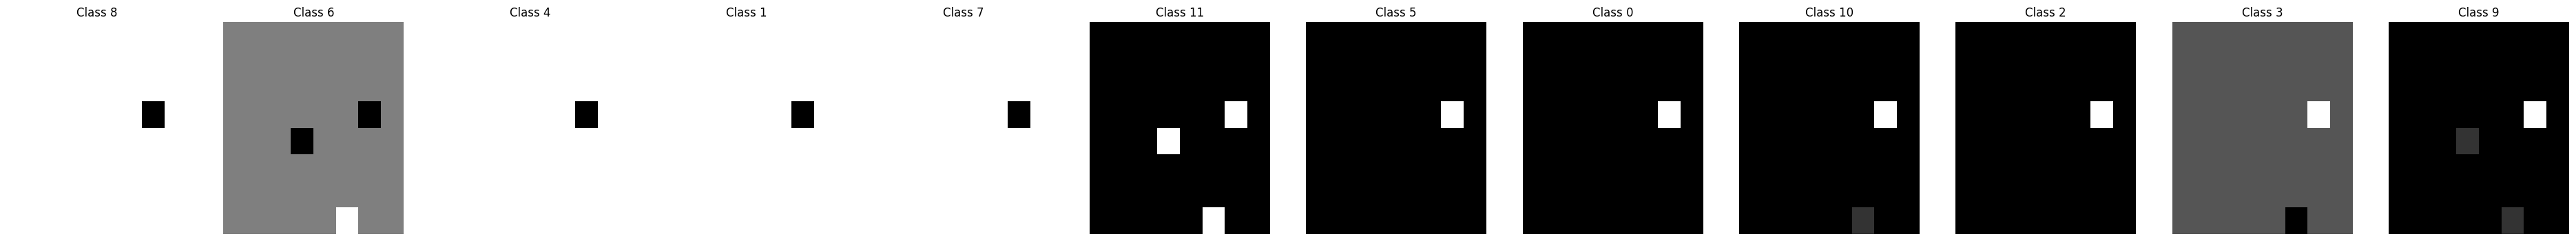

In [ ]:
visualization = DecisionVisualization(decision_tree, num_features=64)
visualization.plot_decision_images()

<div class="alert alert-info" role="alert"><b>Analyze your results in this box.</b>  Answer
</div>